<h3> Predicting Forest Fires in Algeria</h3>

Forest fires are a type of  uncontrolled and unwanted fire that usually have a negative impact. In 2007, forest fires in the Atlas Mountains, located on the northern coast of Algeria, killed several people as it spread rapidly due to hot, dry winds [3]. 

In this project, the main question which we want to answer is:
- Can we predict forest fires given the weather conditions by using $k$ nearest neighbours? 


Our dataset contains weather information on the Sidi Bel Abbès and the Bejaia region, and includes information such as :
- `day`,`month`,`year`: the date of the instance
- `Temperature`: the maximum temperature in degrees celsius
- `RH` : Relative humidity in percentages
- `Ws` : wind speed in kilometers per hour
- `Rain`: total amount of rain, in mm
- `Classes` : whether or not there was fire


The data set also includes indexes:
- `FFMC`: Fine Fuel Moisture Code
- `DMC` : Dull Moisture Code
- `DC`: Drought Code 
- `ISI`: Initial Spread Index
- `BUI`: Buildup Index
- `FWI`: Fire Weather Index

For more information on FWI, you can look at [this website](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi).

First, we load the necessary libraries:

In [15]:
library(tidyverse)
library(GGally)
library(tidymodels)
library(here)
library(testthat)

options(repr.matrix.max.rows = 6)

set.seed(123)

Now we need to load external code files:

In [16]:
source(here('R/convert_to_num.R'))
source(here('R/df_load.R'))
source(here("R/plot_fn.R"))
source(here("R/fire_training_fn.R"))

Checking all the modular tests work well here.

In [21]:
source(here('R/test/test-convert_to_num.R'))
source(here('R/test/test-df_load.R'))
source(here("R/test/test-plot_fn.R"))
source(here("R/test/test-fire_training_fn.R"))

Warning message in file(filename, "r", encoding = encoding):
"cannot open file 'C:/Users/rocky/OneDrive/Desktop/UBC/U3W2/DSCI310/Project/dsci-310-group-10-GCC/R/01-convert_to_num.R': No such file or directory"


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## Package Version Checking ##
Here are the following versions you should have:
- tidyverse: 1.3.2
- repr: 1.1.6
- GGally: 2.1.2
- tidymodels: 1.0.0
- here: 1.0.1
- testthat: 3.16

In [ ]:
packageVersion("tidyverse")
packageVersion("repr")
packageVersion("GGally")
packageVersion("tidymodels")
packageVersion("here")
packageVersion("testthat")
packageVersion("kknn")

[1] ‘1.3.2’

[1] ‘1.1.4’

[1] ‘2.1.2’

[1] ‘1.0.0’

[1] ‘1.0.1’

[1] ‘3.1.2’

[1] ‘1.3.1’

### 1. Loading and wrangling the dataset

The first thing we do is to look at the dataset online, to see what it looks like. At first glance, we can see that this dataset contains headings, and uses commas as a delimiter. Moreover, it seems like each region is stored in a "separate" table on the same dataset. This means that we will need to do some cleaning after we load it to our notebook. 

After inspecting the dataset, we take the data set's url from 
[this website](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++) and load it to our notebook.

The dataset has one table for each region, so we make 2 datasets:

In [ ]:
forest_fires <- df_load(url = "data/Algerian_forest_fires_dataset_UPDATE.csv",
                          skip1 = 1,
                          skip2 = 126,
                          n_max1 = 122,
                          n_max2 = Inf,
                          error_line = 44,
                          error_record = 10:14,
                          correct_bef_error_record = 9,
                          val_corrected = list('14.6',9,12.5,'10.4','fire'),
                          error_col = c('DC', 'FWI'),
                          predicted_factor = 'Classes')

head(forest_fires)

Warning message:
“One or more parsing issues, see `problems()` for details”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
05,06,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
06,06,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


### 2. Exploring the dataset

Usually, we do the preliminary exploratory data analysis with only the training set, so we need to split the `forest_fires` data set into a training and testing set first. Because our dataset is quite small, we decided to have more observations in the training set.|

In [ ]:
set.seed(123)
#We don't want the date columns: our explanation will be given later!
forest_fires <- forest_fires %>%
    select(Temperature:Classes)

# we'll take 75% of the observations and place it on the training set,
#    we use the prop = 0.75 argument to do this
# we also use the strata argument to set which column will be the prediction variable.

fire_split <- initial_split(forest_fires, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

In [ ]:
# as you can see, the number of observations/rows in the training is 
#    0.754 of the forest_fires set
nrow(fire_train)/nrow(forest_fires)

[1] 0.7459016

After making the training set, now we can start exploring the data and decide what predictors to use. Becase everything was recorded in 2012, so we don't want to use `day`, `month` and `year`. We removed these columns right before we split the data into the training and testing. Next, we want to try and summarise the data in different ways:

In [ ]:
#this tells us how many entries are on each factor in Classes

fire_training_count <- fire_train %>%
    group_by(Classes) %>%
    summarise(n = n())

fire_training_count

Classes,n
<fct>,<int>
not fire,79
fire,103


###### table 2.1

From this, we know that there is a pretty equal distribution of observations between the two classes. This is a good thing, because it means we don't need any additional steps such as repeating the observations from the class with less observations.

In [ ]:
# we calculate some important values: 
fire_training_range_fire <- fire_training_fn("fire", range)
fire_training_range_not_fire <- fire_training_fn("not fire", range)

#this shows the average values of the numerical columns when there is fire
fire_training_mean_fire <- fire_training_fn("fire", mean)
fire_training_mean_not_fire <- fire_training_fn("not fire", mean)

In [ ]:
#now, we look at the range of values:
fire_training_range_fire
fire_training_range_not_fire

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27,21,8,0,80.2,3.4,9.7,2.6,5.1,1.7
42,84,21,6,96.0,61.3,220.4,19.0,67.4,30.3


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,42,6,0.0,30.5,0.7,7.0,0,1.1,0.0
35,90,29,16.8,81.8,37.0,180.4,3,37.4,6.1


###### <center>table 2.2.1 and table 2.2.2, showing the range of values for both fire and not fire classes</center>

In [ ]:
# we also want to look at the average values:
fire_training_mean_fire
fire_training_mean_not_fire

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33.94175,56.67961,15.40777,0.1116505,87.47573,20.66699,69.60388,7.515534,23.56796,11.66602


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.05063,69.07595,15.72152,1.507595,66,6.670886,22.78228,1.312658,7.439241,1.001266


###### <center>table 2.2.3 and table 2.2.4, showing the mean for both fire and not fire classes</center>

We can see from table 2.2.1 and 2.2.2 that the range of values for `Ws` is really similar, which is 8-21 and 10-22. Their averages are also really similar, which is 15.42 and 15.725. 

This means that there isn't a clear distinction between the range of values from different `Classes`- and this also means that their averages are too similar. We don't want to use columns like this, because it's probably not going to be useful in differentiating the `Classes`. Another column we might not want to use is`RH`.

Because it's easier to process visual information, we draw some plots:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


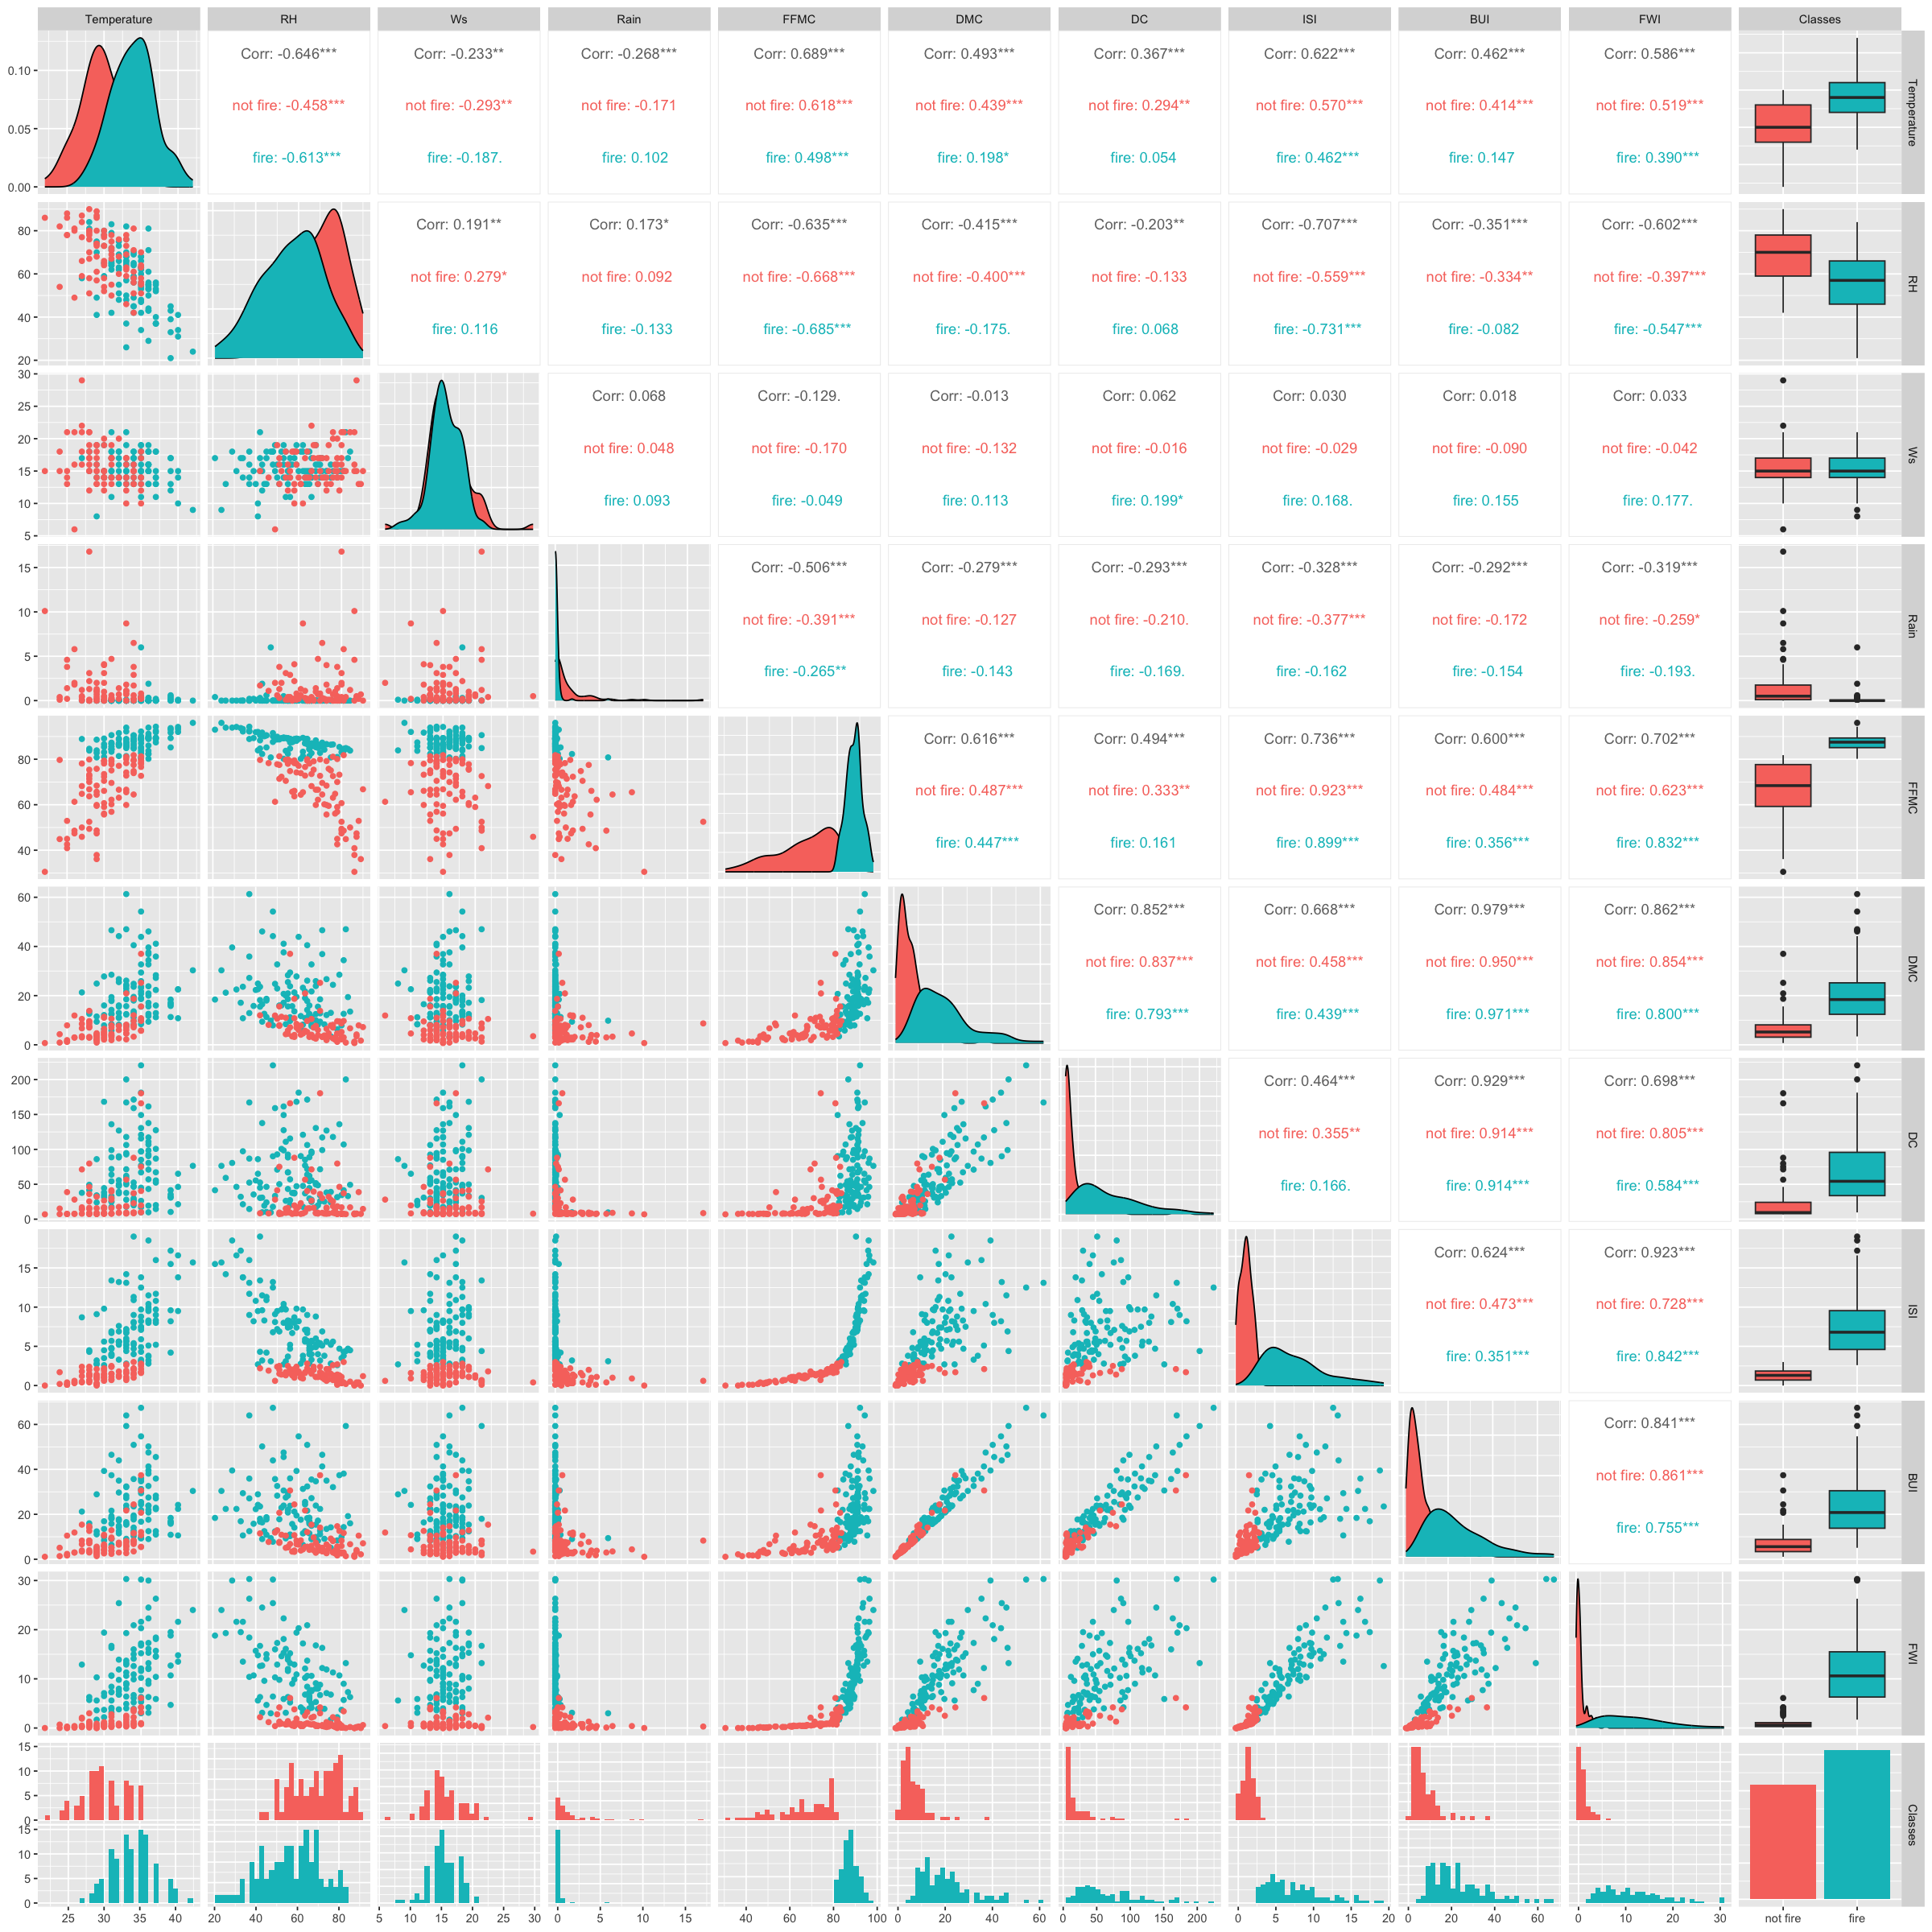

In [ ]:
#resize so we can see the plots
options(repr.plot.width=20, repr.plot.height=20)
#ggpairs was used to do look at our preliminary data analysis, so we can see the general picture
#we add the color argument so we can compare the relationship between the 2 columns and the classes column
fire_train %>% 
    ggpairs(aes(color = Classes))

 ###### <center> fig 2.3 the relationships between 2 columns in the training set</center>

As we can see from this plot, our previous conclusion that values like `Ws` won't be a good choice can be seen by how both rain and not rain `Ws` values overlap - we can't "group" the values into groups of rain/ not rain. 

Based on prior research on FWI indexes[1], we know that they're all calculated based on temperature, relative humidity, wind and rain, which are the `Temperature`,`RH`,`Ws`, and`Rain` columns. Additionally, We also know that `ISI` is calculated from Ws and FFMC, and `BUI` is calculated from DMC and DC. These 2 columns encompass information from other columns, so it seems reasonable that we use them to predict `Classes`. 

To confirm our choice, we make a plot with `ISI`, `BUI` and `Classes` to see if this choice makes sense based on the actual data itself.

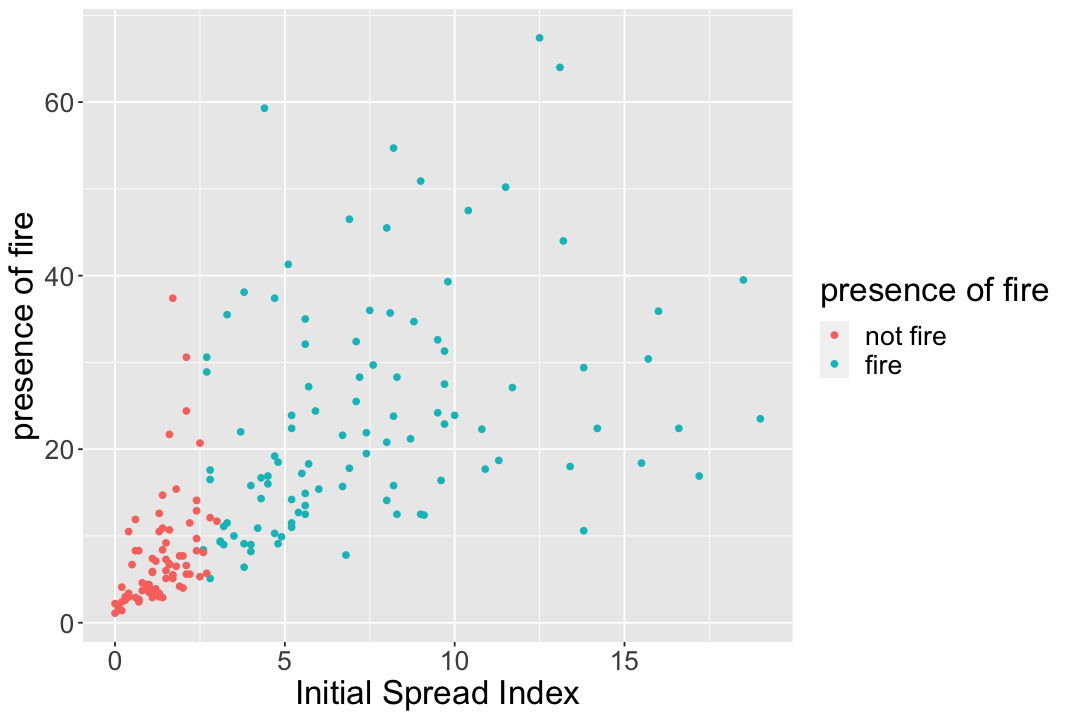

In [ ]:
plot_scatter_graph(data=fire_train, plot_width=8.9, plot_height=6, x_axis_data=ISI, 
                               y_axis_data=BUI, x_axis_label="Initial Spread Index", y_axis_label="presence of fire", 
                               text_size=20, color=Classes, color_label="presence of fire")

######  fig 2.4 ISI and BUI

There is a positive correlation between `ISI` and `BUI`, and there seems to be a distinction between the `Classes`! so `ISI` and `BUI` seems like a reasonable choice. Moreover, because we are only using 2 predictors, it'll be easier to make a visualization of our results. 


Now that we know which predictors to use, we can start making our model.

### 3. Performing the data analysis

Because we are trying to predict `Classes`, which is a categorical variable, with `ISI` AND `BUI`, which are quantitative variables, this is a classification problem. So, we can make a k-nearest classification model, using the  functions from `tidymodels` to help us. Before we can make the model, we need to choose a $k$ value that works. So, we need to tune the classifier.
<br>
The steps are as follows:
1. we make a 10-fold cross validation, to generate the testing and validation sets.
    - because our dataset is relatively small, we decided to use 10-fold instead of 5 fold to compensate for the fewer observations.
2. make the recipe, using `Classes` as the target variable and `ISI` and `BUI` as the predictor variables, using data from the training set.
3. then, we make a model specification with the `nearest_neighbor` function, setting the neighbors to `tune()`.
4. we add this recipe and model to a `workflow()`, using `collect_metrics()` to get the accuracies of each $k$ value.



In [ ]:
set.seed(123)
# making the 10-fold cross validation, 
#    setting the strata (predicted variable) as Classes
fire_vfold <- vfold_cv(fire_train, v = 10, strata = Classes)

# making the recipe, taking the data from the training set and ISI and BUI as the variables we use to predict
# note: we will reuse this recipe later
fire_recipe <- recipe(Classes ~ ISI + BUI, data = fire_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#making the model specification for tuning, setting weight_func to rectangular so that 
#each neighbor has equal "say" and neighbors to tune().
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# k_lots is used to decide the k values we will "try" and check the accuracies for
k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# making the workflow and fitting the recipe and model, and collecting the metrics.
knn_results <- workflow() %>%
  add_recipe(fire_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = fire_vfold, grid = k_lots) %>%
  collect_metrics()

# taking only the accuracies
accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9567251,10,0.01561767,Preprocessor1_Model01
2,accuracy,binary,0.9567251,10,0.01561767,Preprocessor1_Model02
3,accuracy,binary,0.9567251,10,0.01561767,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.9294978,10,0.02100372,Preprocessor1_Model48
49,accuracy,binary,0.9131235,10,0.01960453,Preprocessor1_Model49
50,accuracy,binary,0.9131235,10,0.01960453,Preprocessor1_Model50


######  table 3.1 accuracies

Now, we know how accurate our model is for different $k$ values- but since we have 50 values, it's hard to compare all 50 at once! Again, We plot the accuracies so that we can compare the accuracies between each $k$ value in a more efficient and better way. 

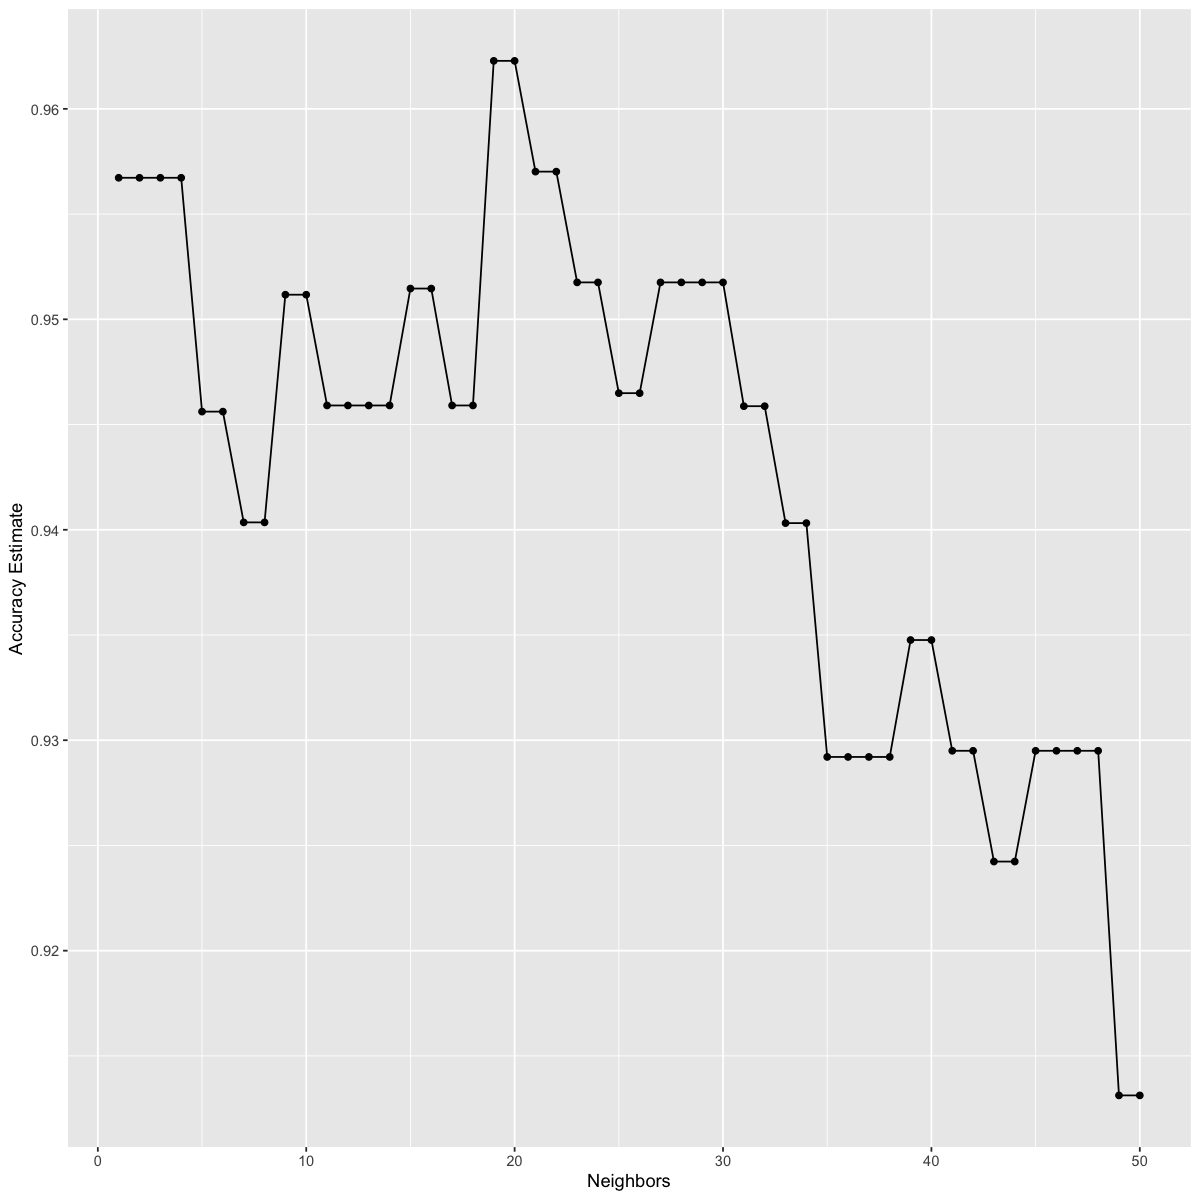

In [ ]:
plot_line_graph(data=accuracies, plot_width=10, plot_height=10, x_axis_data=neighbors, 
                            y_axis_data=mean, x_axis_label="Neighbors", y_axis_label="Accuracy Estimate")

######  fig 3.2

From this graph, we can see the it peaks at about 5/6 and then starts to reduce as $k$ increases. K-nearest model gets slower with larger k values, so  we decided that k = 5 would be the most ideal choice for our model, because of its high accuracy estimate and since this estimate doesn't change much when compared to nearby k values.

This graph also makes sense because we know that small K values tend to have lower accuracies due to underfitting, while large k values will also have lower accuracies due to overfitting. In this graph, accuracies initially increase, and then generally decreases as $k$ values increase.

Now that we know what k value to use, we make a new model specification, this time setting k to 5. We add this new model and the recipe to a `workflow`.

In [ ]:
#we don't need to make a new recipe, since we can reuse the recipe from the last step.

# making the model specification, this time specifying the number of neighbors we want
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# fitting the spec and recipe to the workflow
knn_fit <- workflow() %>%
  add_recipe(fire_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = fire_train)


Now, that we have a model, we can use it to predict the classes on our testing set!

In [ ]:
# we use the knn_fit to predict the class in fire_test, and then we add that .pred_class column to the testing set. 
fire_test_predictions <- predict(knn_fit, fire_test) %>%
  bind_cols(fire_test)

fire_test_predictions

.pred_class,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not fire,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
not fire,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
fire,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fire,36,33,13,0.1,90.6,25.8,77.8,9.0,28.2,15.4,fire
not fire,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire
not fire,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


######  table 3.3 the `pred_class` column shows the class our model predicted

To get a better picture on how well our model predicted the testing set's classes, we can get the metrics and the confusion matrix:

In [ ]:
# getting the confusion matrix, setting the "real" column to Classes and the predicted column .pred_class

fire_test_predictions %>%
  conf_mat(truth = Classes, estimate = .pred_class)

          Truth
Prediction not fire fire
  not fire       27    0
  fire            0   35

###### fig 3.4 the confusion matrix

From this confusion matrix, we can see that it predicted not fire correctly in 25 cases, predicted fire correctly in 32 cases and predicted incorrectly in only 3 cases. This means that the accuracy of our model might be quite high. Now, we look at the accuracy metrics using the `metrics` argument:

In [ ]:
# getting the metrics, setting the "real" column to Classes and the predicted column .pred_class
fire_test_predictions %>%
  metrics(truth = Classes, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,1


###### table 3.5, showing the accuracy of our model

It turns out our accuracy is 95%! This is pretty high, so we can be quite confident that our model will predict if there are forest fires quite accurately. 

Finally, we create graph to show the predicted classes (the colored background) and the actual class.

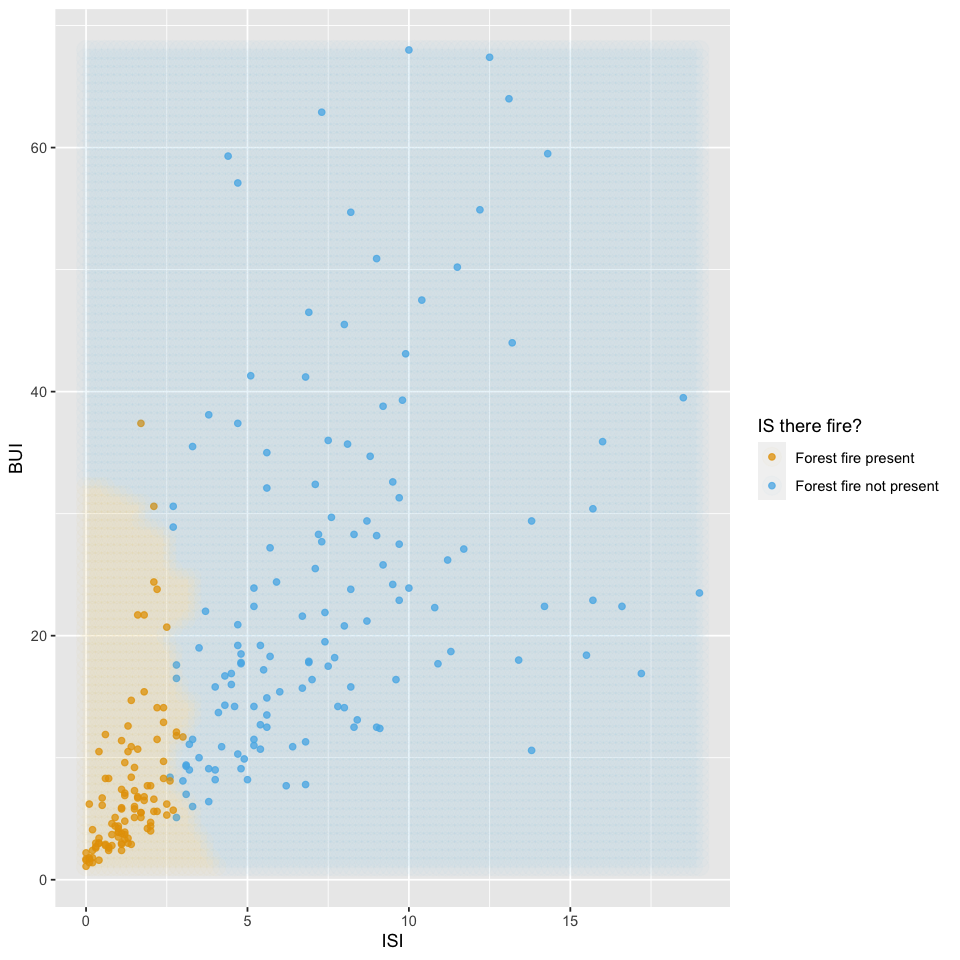

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")

# create the grid of area/smoothness vals, and arrange in a data frame
# forest_fires$BUI means forest_fire df, BUI column

isi_grid <- seq(min(forest_fires$ISI), max(forest_fires$ISI), length.out = 100)
bui_grid <- seq(min(forest_fires$BUI), max(forest_fires$BUI), length.out = 100)
asgrid <- as_tibble(expand.grid(ISI = isi_grid, BUI = bui_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Classes = .pred_class)

# plot a graph
wkflw_plot <-
  ggplot() +
  geom_point(data = forest_fires, mapping = aes(x = ISI, y = BUI, color = Classes), alpha = 0.75) +
  geom_point(data = prediction_table, mapping = aes(x = ISI, y = BUI, color = Classes), alpha = 0.02, size = 5.) +
  labs(color = "IS there fire?") +
  scale_color_manual(labels = c("Forest fire present", "Forest fire not present"), values = cbPalette)

wkflw_plot

###### fig 3.6

From this graph, we can conclude that our model works fine - almost all the predictions are accurate. The colors don't seem to look patchy, which means that we didn't underfit this model. most of the observations were predicted correctly too.

### 4. Wrapping it all up

In this project, we made a model to predict whether or not there will be a forest fire based on information given at the time of the observation. We found that we could in fact predict the presence of fire with a high accuracy by using a k-nearest classification model and using ISI and BUI as our predictor variables. 

This was what we expected to find, because there had already been a strong relationship between ISI and BUI. Moreover, based on our preliminary data analysis we can already see that in both ISI and BUI, there is a somewhat clear distinction between values when there is or isn't any fire.  

**Expected outcomes and significance:**

 We hope that in the future, something like this can be used to predict real fires. Predicting fire will  be beneficial because it means we can mobilise firefighters faster, which helps stop the spread of fires. Hopefully, this can also lead to other questions, such as predicting the magnitude of a fire.


*Citations:*


[1] Faroudja ABID et al. , â€œPredicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithmâ€, International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019) , 08 - 11 July , 2019, Marrakech, Morocco.


[2]  Canadian Wildland Fire Information System | Canadian Forest Fire Weather Index (FWI) System, 2021.Retrieved 1 April 2021  from https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

[3] Fires in Algeria. (2021). Retrieved 1 April 2021, from https://earthobservatory.nasa.gov/images/18959/fires-in-algeria

[4] Template project used for reference in creation of this analysis: "https://github.com/UBC-DSCI/predict-airbnb-nightly-price/tree/v1.0.2"